In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy import stats
import statistics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error, make_scorer
import seaborn as sns
import os
from scipy.stats import skew, probplot, norm
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso, ElasticNet 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

### importing data

In [7]:
training = pd.read_csv('./df_whole_train_cleaned.csv')
test = pd.read_csv('./df_whole_test_cleaned.csv')
print(f'training dataset has {training.shape}')
print(f'test dataset has {test.shape}')


training dataset has (88008, 78)
test dataset has (88008, 78)


In [3]:
training_set.describe().loc['std'].values[2:]


array([0.93601143, 0.99054053, 0.98005684, 0.87226901, 0.9933063 ,
       0.41178871, 0.87773681, 0.79252405, 0.23433094, 0.15950733,
       0.06194526, 0.43639349, 0.        , 0.65991208, 0.61873053,
       0.03014651, 0.50138535, 0.46929316, 0.0991349 , 0.03215194,
       0.01167682, 0.04168659, 1.0862633 , 0.16708293, 0.02235839,
       0.00674169, 0.00674169, 0.        , 0.49633251, 0.42676747,
       0.30950673, 0.88216516, 0.92902653, 0.39144303, 0.08091324,
       0.4352806 , 0.14030586, 0.12091118, 0.15158648, 0.4985081 ,
       0.4985081 , 0.03580978, 0.07873516, 0.1205001 , 0.18769195,
       0.29116922, 0.37592058, 0.41594437, 0.43795003, 0.3746702 ,
       0.16250752, 0.3899001 , 0.3013935 , 0.01065901, 0.45290118,
       0.35888833, 0.4398229 , 0.22951779, 0.22706011, 0.00753727,
       0.24973716, 0.46213791, 0.24472372, 0.49639043, 0.45814404,
       0.27203845, 0.29469   , 0.21996632, 0.25550125, 0.21998952,
       0.3147536 , 0.29840736, 0.34824459, 0.74646947, 0.57871

In [89]:
training_set = training_set.drop(['encounter_id','patient_nbr'], axis = 1)


In [90]:
test_set = test_set.drop(['encounter_id','patient_nbr'], axis = 1)

In [91]:
test_set.head(5)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,...,diag_1_digestive,diag_1_genitourinary,diag_1_injury,diag_1_musculoskeletal,diag_1_neoplasms,diag_1_other,diag_1_respiratory,number_outpatient_log1p,number_emergency_log1p,number_inpatient_log1p
0,-0.801560,0.412639,0.978144,-0.615110,-1.752584,0,1,0,0,0,...,0,0,0,0,0,0,1,-0.401127,-0.323001,-0.635161
1,-0.464698,2.197448,-0.196348,-0.120992,0.823365,0,0,0,0,0,...,0,0,0,0,0,0,1,1.213384,-0.323001,0.724186
2,2.903921,2.299437,2.152636,2.226068,0.823365,0,0,0,0,0,...,0,0,0,0,0,0,1,-0.401127,-0.323001,-0.635161
3,-0.464698,-1.066202,-0.783594,-0.615110,-0.722205,0,0,2,0,0,...,0,0,0,0,0,0,0,1.213384,-0.323001,1.519353
4,0.209026,1.279546,-0.196348,1.114303,0.823365,0,0,0,0,0,...,0,0,1,0,0,0,0,-0.401127,1.873944,-0.635161


In [92]:
training_set.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'med_dosage_change', 'number_of_medicine', 'race_AfricanAmerican',
       'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'race_unknown', 'gender_Female', 'gender_Male', 'age_0-10', 'age_10-20',
       'age_20-30', 'age_30-40', 'age_40-50', 'age_50-60', 'age_60-70',
       'age_70-80', 'age_80-90', 'age_90-100', 'admission_type_id_elective',
       'admission_type_id_na', 'admission_ty

In [106]:

X = training_set.loc[:, training_set.columns !='readmitted']
y = training_set[['readmitted']]

In [108]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

In [109]:
#set up test and train split from the training data set
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=123)


In [110]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

In [111]:
#kfold for cross validation
kf = KFold(n_splits = 5, shuffle = True, random_state = 28)


In [112]:
#set up xgb with random parameter
xgb = XGBRegressor()
xgb.set_params(random_state=123)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# fit X_train and y_train with xgb
xgb.fit(X_train, y_train)


[16:08:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [113]:
#get R^2 for the test and train set
print("The train set R^2 is: %.5f" % xgb.score(X_train, y_train))
print("The test set R^2 is is: %.5f" % xgb.score(X_valid, y_valid))

XGBoostError: need to call fit or load_model beforehand

In [47]:
xgb.predict(X_valid)

array([-inf, -inf, -inf, ..., -inf, -inf, -inf], dtype=float32)

In [50]:
# Initial prediction with the random parameters
xgb_pred = xgb.predict(X_valid)

# Calculate the absolute errors
errors = abs(np.expm1(xgb_pred) - np.expm1(y_valid).values)

# Print out MAE, MSE, and RMSE
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('Mean Squared Error (MSE):', mean_squared_error(y_valid, xgb_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_valid, xgb_pred)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(y_valid).values)
print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')

Mean Absolute Error (MAE): $ 0.12


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [49]:
xgb_pred

array([-inf, -inf, -inf, ..., -inf, -inf, -inf], dtype=float32)

### random search xbgoost

In [17]:
#parameter tuning using randomsearch
xgb_param_grid ={'learning_rate': [0.01, 0.05, 0.1],
                 'max_depth': [2, 3, 4, 5, 6],
                 'min_child_weight': [4, 5, 6],
                 'n_estimators': [400, 450, 500, 550, 600]}

random_search_xgb = RandomizedSearchCV(xgb, xgb_param_grid, scoring='neg_mean_squared_error', 
                                     cv= kf, n_jobs=-1, return_train_score = True)

%time random_search_xgb.fit(X_train, y_train)

[14:48:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 10.9 s, sys: 111 ms, total: 11 s
Wall time: 2min 8s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1,...
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='warn', n_iter=10, n_

In [18]:
#get best best parameters from random search
random_search_xgb.best_params_

{'n_estimators': 550,
 'min_child_weight': 4,
 'max_depth': 3,
 'learning_rate': 0.05}

In [19]:
random_xgb = random_search_xgb.best_estimator_

In [20]:
print("The train set R^2 is: %.5f" % random_xgb.score(X_train, y_train))
print("The test set R^2 is is: %.5f" % random_xgb.score(X_test, y_test))

The train set R^2 is: 0.97966
The test set R^2 is is: 0.91419


In [21]:
#Prediction with tuned hyperparameters
random_xgb_pred = random_xgb.predict(X_test)

# Calculate the absolute errors
errors = abs(np.expm1(random_xgb_pred) - np.expm1(y_test).SalePrice)

# Print out MAE, MSE, and RMSE
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, random_xgb_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_test, random_xgb_pred)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(y_test).SalePrice)
print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')

Mean Absolute Error (MAE): $ 14770.92
Mean Squared Error (MSE): 0.014224391721233895
Root Mean Square Error (RMSE): 0.11926605435426249
Mean Absolute Percent Error (MAPE): 8.78 %.


In [22]:
#further fine tuning parameters

xgb_param_grid1 ={'learning_rate': [0.01],
                 'max_depth': [3],
                 'min_child_weight': [0],
                 'n_estimators': [3460],
                 'subsample': [0.7],
                 'colsample_bytree' : [0.7],
                 'objective':['reg:linear'],
                 'nthread':[-1],
                 'scale_pos_weight':[1],
                 'seed':[27],
                 'reg_alpha': [0.00006]}

random_search_xgb1 = RandomizedSearchCV(xgb, xgb_param_grid1, scoring='neg_mean_squared_error', 
                                     n_jobs=-1, return_train_score = True)

%time random_search_xgb1.fit(X_train, y_train)                 


[14:50:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 50.4 s, sys: 142 ms, total: 50.5 s
Wall time: 1min 26s


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          rand...
                   param_distributions={'colsample_bytree': [0.7],
                                        'learning_rate': [0.01],
                                        'max_depth': [3],

In [23]:
random_search_xgb1.best_params_

{'subsample': 0.7,
 'seed': 27,
 'scale_pos_weight': 1,
 'reg_alpha': 6e-05,
 'objective': 'reg:linear',
 'nthread': -1,
 'n_estimators': 3460,
 'min_child_weight': 0,
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7}

In [24]:
random_xgb1 = random_search_xgb1.best_estimator_

In [25]:
print("The train set R^2 is: %.5f" % random_xgb1.score(X_train, y_train))
print("The test set R^2 is is: %.5f" % random_xgb1.score(X_test, y_test))

The train set R^2 is: 0.98811
The test set R^2 is is: 0.91490


In [26]:
# Train Data
random_xgb_pred1 = random_xgb1.predict(X_train)

# Calculate the absolute errors
errors = abs(np.expm1(random_xgb_pred1) - np.expm1(y_train).values)

# Print out MAE, MSE, and RMSE
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('Mean Squared Error (MSE):', mean_squared_error(y_train, random_xgb_pred1))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_train, random_xgb_pred1)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(y_train).values)
print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')

Mean Absolute Error (MAE): $ 79750.72
Mean Squared Error (MSE): 0.0018731659770432737
Root Mean Square Error (RMSE): 0.04328008753506945
Mean Absolute Percent Error (MAPE): 48.85 %.


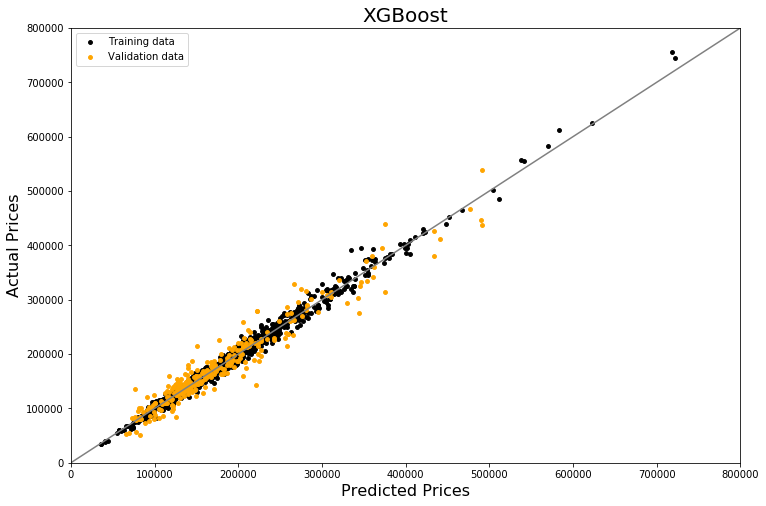

<Figure size 432x288 with 0 Axes>

In [27]:
y_train_xgboost = random_xgb1.predict(X_train)
y_test_xgboost = random_xgb1.predict(X_test)

# Plot predictions
plt.figure(figsize=(12,8))
plt.scatter(np.expm1(y_train_xgboost), np.expm1(y_train), c='black', marker="o", s=15, label = "Training data")
plt.scatter(np.expm1(y_test_xgboost), np.expm1(y_test), c='orange', marker='o', s=15, label = "Validation data")
plt.title("XGBoost", fontsize = 20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.legend(loc = "upper left")
plt.plot([0, 800000], [0, 800000], c = "grey")
plt.show()
plt.savefig('XGBoost Training and Validation Plot.png', dpi=300,bbox_inches='tight')


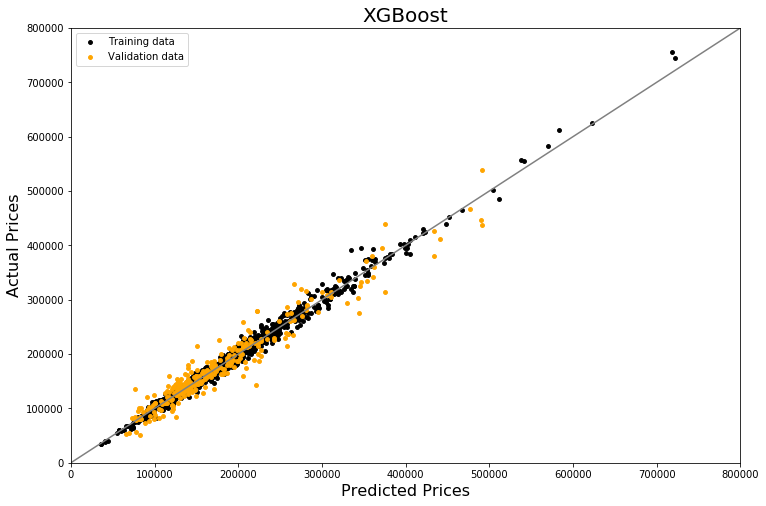

In [28]:
plt.figure(figsize=(12,8))
plt.scatter(np.expm1(y_train_xgboost), np.expm1(y_train), c='black', marker="o", s=15, label = "Training data")
plt.scatter(np.expm1(y_test_xgboost), np.expm1(y_test), c='orange', marker='o', s=15, label = "Validation data")
plt.title("XGBoost", fontsize = 20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.legend(loc = "upper left")
plt.plot([0, 800000], [0, 800000], c = "grey")
plt.savefig('XGBoost Training and Validation Plot.png', dpi=300,bbox_inches='tight')

In [29]:

# Get numerical feature importances
importances_xgb = list(xgb.feature_importances_)

# List of tuples with variable and importance
feature_importances_xgb = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, importances_xgb)]

# Sort the feature importances by most important first
xgb_feature_importances = sorted(feature_importances_xgb, key = lambda x: x[1], reverse = True )

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in xgb_feature_importances]



Variable: GarageCars           Importance: 0.17529000341892242
Variable: Ppf_Adj              Importance: 0.11455000191926956
Variable: T_Sf                 Importance: 0.0604499988257885
Variable: MSZoning__RL         Importance: 0.045090001076459885
Variable: Fireplaces           Importance: 0.04366999864578247
Variable: YearBuilt            Importance: 0.040550000965595245
Variable: YearRemodAdd         Importance: 0.035020001232624054
Variable: GarageType__Attchd   Importance: 0.025860000401735306
Variable: BsmtQual__Ex         Importance: 0.023310000076889992
Variable: KitchenQual__Ex      Importance: 0.020589999854564667
Variable: KitchenQual__Gd      Importance: 0.018969999626278877
Variable: GarageCond__TA       Importance: 0.016690000891685486
Variable: CentralAir__N        Importance: 0.015490000136196613
Variable: TotalBsmtSF          Importance: 0.011989999562501907
Variable: SaleCondition__Normal Importance: 0.011540000326931477
Variable: MSZoning__RM         Importance: 0

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [30]:
xgb_feature_importances_top20 = xgb_feature_importances[:20]
featureNames, featureScores = zip(*list(xgb_feature_importances_top20))

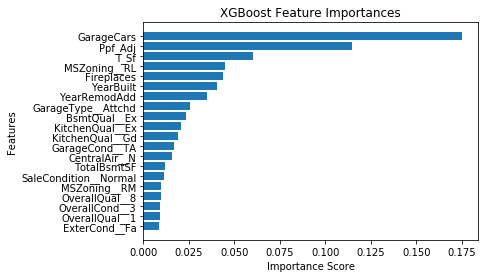

In [31]:
plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.gca().invert_yaxis()
plt.title('feature importance')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('XGBoost Feature Importances')

plt.savefig('XGBoost Feature Importance.png', dpi=300,bbox_inches='tight')


In [32]:
np.expm1(random_xgb1.predict(X)).round()

array([202943., 176051., 210443., ..., 262785., 147223., 154369.],
      dtype=float32)

In [33]:
X['train_predicted_price'] = np.expm1(random_xgb1.predict(X)).round()

In [38]:
X['SalePrice'] = np.expm1(y).round()

In [41]:
X.head(5)

,Id,Ppf_Adj,T_Sf,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType__Oth,SaleType__WD,SaleCondition__Abnorml,SaleCondition__AdjLand,SaleCondition__Alloca,SaleCondition__Family,SaleCondition__Normal,SaleCondition__Partial,train_predicted_price,SalePrice
0,1,135.125,2238.52,65.0,8450,2003,2003,196,706,0,...,0,1,0,0,0,0,1,0,202943.0,208499.0
1,2,129.250,2138.60,80.0,9600,1976,1976,0,978,0,...,0,1,0,0,0,0,1,0,176051.0,181499.0
2,3,135.125,2242.44,68.0,11250,2001,2002,162,486,0,...,0,1,0,0,0,0,1,0,210443.0,223499.0
3,4,135.125,2269.48,60.0,9550,1915,1970,0,216,0,...,0,1,1,0,0,0,0,0,145346.0,139999.0
4,5,135.125,2931.38,84.0,14260,2000,2000,350,655,0,...,0,1,0,0,0,0,1,0,270507.0,249999.0


In [43]:
X.to_csv('trainset7_updated_predicted_price.csv')


In [44]:
#drop SalePrice column from test_set
test_set = test_set.loc[:, test_set.columns !='SalePrice']


In [45]:
test_set['predicted_Sale_Price'] = (np.expm1(random_xgb1.predict(test_set))).round()

In [46]:

test_set.to_csv('test_set7_updated_predicted_price.csv')


In [47]:
test_set.head(5)

,Id,Ppf_Adj,T_Sf,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType__New,SaleType__Oth,SaleType__WD,SaleCondition__Abnorml,SaleCondition__AdjLand,SaleCondition__Alloca,SaleCondition__Family,SaleCondition__Normal,SaleCondition__Partial,predicted_Sale_Price
1455,1461,111.625,1512.64,80.0,11622,1961,1961,0,468,144,...,0,0,1,0,0,0,0,1,0,123072.0
1456,1462,129.250,2295.26,81.0,14267,1958,1958,108,923,0,...,0,0,1,0,0,0,0,1,0,163656.0
1457,1463,111.625,2320.66,74.0,13830,1997,1998,0,791,0,...,0,0,1,0,0,0,0,1,0,187152.0
1458,1464,129.250,2327.16,78.0,9978,1998,1998,20,602,0,...,0,0,1,0,0,0,0,1,0,195786.0
1459,1465,135.125,1879.82,43.0,5005,1992,1992,0,263,0,...,0,0,1,0,0,0,0,1,0,193529.0


### Random Forest

In [52]:

rforest = RandomForestRegressor()

rforest.set_params(random_state=52)

# Train the model on training data
rforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=52, verbose=0,
                      warm_start=False)

In [53]:
print("The train set R^2 is: %.5f" % rforest.score(X_train, y_train))
print("The test set R^2 is is: %.5f" % rforest.score(X_test, y_test))

The train set R^2 is: 0.97687
The test set R^2 is is: 0.86527


In [54]:
# Initial prediction
rforest_pred = rforest.predict(X_test)

# Calculate the absolute errors
errors = np.abs(np.expm1(rforest_pred) - np.expm1(y_test).SalePrice)

# Print out MAE, MSE, and RMSE
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, rforest_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_test, rforest_pred)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(y_test.SalePrice))
print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')


Mean Absolute Error (MAE): $ 19454.27
Mean Squared Error (MSE): 0.022332551496737994
Root Mean Square Error (RMSE): 0.14944079595859355
Mean Absolute Percent Error (MAPE): 11.15 %.


In [55]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score


In [56]:
param_grid ={'max_depth': [20, 25, 30],
             'max_features': ['auto','sqrt','log2'],
             'min_samples_split':[2,3,4],
             'min_samples_leaf':[1, 3, 5],
             'n_estimators': [500, 750, 1000, 1250, 1500]}

In [57]:
random_search_rforest = RandomizedSearchCV(rforest, param_grid, n_iter=100, scoring='neg_mean_squared_error', 
                                      n_jobs=-1, return_train_score = True)

%time random_search_rforest.fit(X_train, y_train)

CPU times: user 30.5 s, sys: 338 ms, total: 30.8 s
Wall time: 6min 40s


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=None,
                                                   oob_score=False,
                                                   random_st...0

In [58]:

# get the best parameters
random_search_rforest.best_params_

{'n_estimators': 1250,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 30}

In [59]:
# Prediction using the tuned parameters
random_rforest = random_search_rforest.best_estimator_

In [60]:
print("The train set R^2 is: %.5f" % random_rforest.score(X_train, y_train))
print("The test set R^2 is is: %.5f" % random_rforest.score(X_test, y_test))

The train set R^2 is: 0.98459
The test set R^2 is is: 0.88496


In [61]:
# Train Data
random_rforest_pred = random_rforest.predict(X_train)

# Calculate the absolute errors
errors = abs(np.expm1(random_rforest_pred) - np.expm1(y_train).SalePrice)

# Print out MAE, MSE, and RMSE
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('Mean Squared Error (MSE):', mean_squared_error(y_train, random_rforest_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_train, random_rforest_pred)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(y_train).SalePrice)
print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')

Mean Absolute Error (MAE): $ 5883.35
Mean Squared Error (MSE): 0.002427254513813179
Root Mean Square Error (RMSE): 0.04926717481054885
Mean Absolute Percent Error (MAPE): 3.36 %.


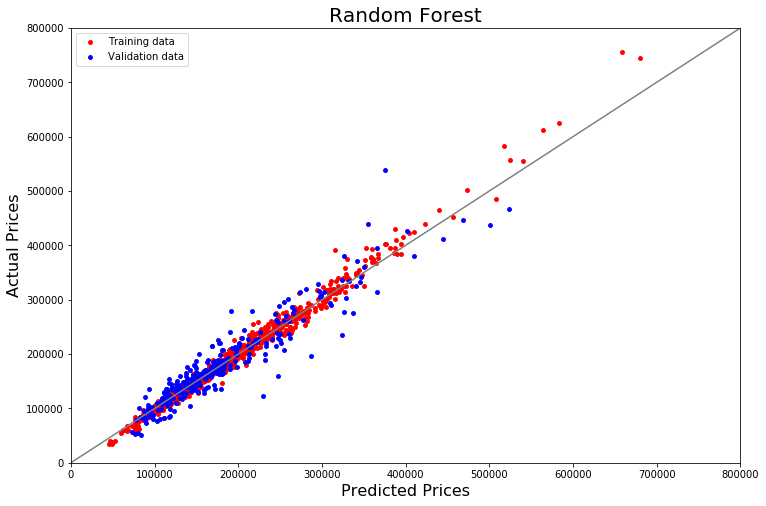

In [63]:

y_train_rForest = random_rforest.predict(X_train)
y_test_rForest = random_rforest.predict(X_test)

# Plot predictions
plt.figure(figsize=(12,8))
plt.scatter(np.expm1(y_train_rForest), np.expm1(y_train), c='red', marker="o", s=15, label = "Training data")
plt.scatter(np.expm1(y_test_rForest), np.expm1(y_test), c='blue', marker='o', s=15, label = "Validation data")
plt.title("Random Forest", fontsize = 20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.legend(loc = "upper left")
plt.plot([0, 800000], [0, 800000], c = "grey")
plt.show()

In [64]:
train_predicted_price = np.expm1(random_rforest.predict(X))


In [65]:
train_predicted_price

array([211389.1456428 , 176228.26241096, 219530.92173319, ...,
       262809.70289998, 142249.37851247, 151376.13108466])

In [66]:
X['train_predicted_price'] = train_predicted_price

In [67]:
X['SalePrice'] = np.expm1(y)

In [68]:
trainset_updated_predicted_price = X


In [70]:
trainset_updated_predicted_price.sample(5)

,Id,Ppf_Adj,T_Sf,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType__Oth,SaleType__WD,SaleCondition__Abnorml,SaleCondition__AdjLand,SaleCondition__Alloca,SaleCondition__Family,SaleCondition__Normal,SaleCondition__Partial,train_predicted_price,SalePrice
785,788,135.125,2610.72,76.000000,10142,2004,2004,0,656,0,...,0,1,0,0,0,0,1,0,237780.145150,232999.0
1200,1205,111.625,1708.00,78.000000,10140,1975,1975,0,788,0,...,0,1,0,0,0,0,1,0,149990.711074,153499.0
504,506,111.625,2228.80,60.000000,7596,1952,1952,360,0,0,...,0,0,0,0,0,0,1,0,126550.930686,124499.0
277,279,141.000,2957.84,107.000000,14450,2006,2007,315,0,0,...,0,0,0,0,0,0,0,1,397111.367845,415297.0
658,661,135.125,2469.20,81.517647,12384,1976,1976,233,0,0,...,0,1,0,0,0,0,1,0,198033.192012,197899.0


In [71]:
trainset_updated_predicted_price.to_csv('rf_trainset_updated_predicted_price.csv')


In [80]:
#drop SalePrice column from test_set
test_set = test_set.loc[:, test_set.columns !='SalePrice']

In [81]:
test_set['predicted_Sale_Price'] = (np.expm1(random_rforest.predict(test_set))).round()


In [82]:
test_set.to_csv('rf_test_set_updated_predicted_price.csv')


In [83]:
test_set.head(5)

,Id,Ppf_Adj,T_Sf,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType__New,SaleType__Oth,SaleType__WD,SaleCondition__Abnorml,SaleCondition__AdjLand,SaleCondition__Alloca,SaleCondition__Family,SaleCondition__Normal,SaleCondition__Partial,predicted_Sale_Price
1455,1461,111.625,1512.64,80.0,11622,1961,1961,0,468,144,...,0,0,1,0,0,0,0,1,0,125522.0
1456,1462,129.250,2295.26,81.0,14267,1958,1958,108,923,0,...,0,0,1,0,0,0,0,1,0,150821.0
1457,1463,111.625,2320.66,74.0,13830,1997,1998,0,791,0,...,0,0,1,0,0,0,0,1,0,179535.0
1458,1464,129.250,2327.16,78.0,9978,1998,1998,20,602,0,...,0,0,1,0,0,0,0,1,0,186124.0
1459,1465,135.125,1879.82,43.0,5005,1992,1992,0,263,0,...,0,0,1,0,0,0,0,1,0,189756.0


In [36]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [37]:

para= {"learning_rate" : [0.01,0.1,1],
       "n_estimators": [200,500,1000,2000,3000,4000],
       "max_depth" : [3,4,5,6],
       "subsample" : [0.8,0.9,1],
       "colsample_bytree" : [0.8,0.9,1]}

In [38]:
xgboost = xgb.XGBRegressor()
n_iter_search = 2
ran_search_xgb=RandomizedSearchCV(estimator=xgboost, param_distributions=para,n_iter=n_iter_search,
                                  scoring='neg_mean_squared_error', cv=5, return_train_score=True)

In [39]:
import time


In [41]:
xgboost2 = xgb.XGBClassifier()
n_iter_search =2
ran_search_xgb=RandomizedSearchCV(estimator=xgboost, param_distributions=para,n_iter=n_iter_search,
                                 scoring='roc_auc', cv=5, return_train_score=True)
# model 2

In [50]:
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as ms

train_error =[]
test_error = []
s = []
logit = LogisticRegression()
for i in range(5):
    X_train, X_valid, y_train, y_valid = ms.train_test_split(X, y, test_size=0.2, random_state=i)
    logit.fit(X_train, y_train)
    train_error.append(1 - logit.score(x_train, y_train))
    test_error.append(1 - logit.score(X_valid, y_valid))
    s.append(logit.score(x_train, y_train))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [56]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88008 entries, 0 to 88007
Data columns (total 75 columns):
time_in_hospital                     88008 non-null float64
num_lab_procedures                   88008 non-null float64
num_procedures                       88008 non-null float64
num_medications                      88008 non-null float64
number_diagnoses                     88008 non-null float64
max_glu_serum                        88008 non-null int64
A1Cresult                            88008 non-null int64
metformin                            88008 non-null int64
repaglinide                          88008 non-null int64
nateglinide                          88008 non-null int64
chlorpropamide                       88008 non-null int64
glimepiride                          88008 non-null int64
acetohexamide                        88008 non-null int64
glipizide                            88008 non-null int64
glyburide                            88008 non-null int64
tolbutamide

In [57]:
X.select_dtypes(include=['float64'])


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,med_dosage_change,number_of_medicine,number_outpatient_log1p,number_emergency_log1p,number_inpatient_log1p
0,-0.801560,0.412639,0.978144,-0.615110,-1.752584,-0.589086,-1.287246,-0.401127,-0.323001,-0.635161
1,-0.464698,2.197448,-0.196348,-0.120992,0.823365,-0.589086,-1.287246,1.213384,-0.323001,0.724186
2,2.903921,2.299437,2.152636,2.226068,0.823365,1.460590,-0.203098,-0.401127,-0.323001,-0.635161
3,-0.464698,-1.066202,-0.783594,-0.615110,-0.722205,-0.589086,1.965199,1.213384,-0.323001,1.519353
4,0.209026,1.279546,-0.196348,1.114303,0.823365,-0.589086,0.881051,-0.401127,1.873944,-0.635161
5,-0.127836,1.177557,1.565390,0.620185,-0.722205,-0.589086,0.881051,1.213384,-0.323001,0.724186
6,0.545888,-1.321175,-0.783594,-0.862169,-2.267774,1.460590,-0.203098,-0.401127,1.873944,-0.635161
7,-0.801560,0.004683,2.739882,-0.368051,-0.722205,-0.589086,0.881051,-0.401127,-0.323001,-0.635161
8,-0.801560,0.463634,0.978144,-0.368051,0.823365,-0.589086,-0.203098,1.213384,-0.323001,-0.635161
9,-0.127836,2.044464,-0.783594,-0.368051,0.823365,-0.589086,-0.203098,2.157812,-0.323001,0.724186


In [60]:
X.fillna(X.mean())

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,...,diag_1_digestive,diag_1_genitourinary,diag_1_injury,diag_1_musculoskeletal,diag_1_neoplasms,diag_1_other,diag_1_respiratory,number_outpatient_log1p,number_emergency_log1p,number_inpatient_log1p
0,-0.801560,0.412639,0.978144,-0.615110,-1.752584,0,1,0,0,0,...,0,0,0,0,0,0,1,-0.401127,-0.323001,-0.635161
1,-0.464698,2.197448,-0.196348,-0.120992,0.823365,0,0,0,0,0,...,0,0,0,0,0,0,1,1.213384,-0.323001,0.724186
2,2.903921,2.299437,2.152636,2.226068,0.823365,0,0,0,0,0,...,0,0,0,0,0,0,1,-0.401127,-0.323001,-0.635161
3,-0.464698,-1.066202,-0.783594,-0.615110,-0.722205,0,0,2,0,0,...,0,0,0,0,0,0,0,1.213384,-0.323001,1.519353
4,0.209026,1.279546,-0.196348,1.114303,0.823365,0,0,0,0,0,...,0,0,1,0,0,0,0,-0.401127,1.873944,-0.635161
5,-0.127836,1.177557,1.565390,0.620185,-0.722205,0,0,0,0,0,...,0,0,0,0,0,0,0,1.213384,-0.323001,0.724186
6,0.545888,-1.321175,-0.783594,-0.862169,-2.267774,1,0,0,0,0,...,0,0,0,0,0,1,0,-0.401127,1.873944,-0.635161
7,-0.801560,0.004683,2.739882,-0.368051,-0.722205,0,0,2,0,0,...,0,0,0,0,0,0,0,-0.401127,-0.323001,-0.635161
8,-0.801560,0.463634,0.978144,-0.368051,0.823365,0,1,0,0,0,...,0,0,0,0,0,0,0,1.213384,-0.323001,-0.635161
9,-0.127836,2.044464,-0.783594,-0.368051,0.823365,0,0,2,0,0,...,0,0,1,0,0,0,0,2.157812,-0.323001,0.724186
